<a href="https://colab.research.google.com/github/vyvy-2001/Evaluation-of-Recommendation-Systems-techniques/blob/main/The_Evaluation_of_Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'movies-and-ratings-for-recommendation-system:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3747724%2F6486174%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240912%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240912T070016Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3d596101b833c7d136fddeca91eae23ad9cee3428884da22c99e8da7bf82284653e6c837f31dbcf66792e6b5c1ab84aba0d4fd7c9b94676fe664f76b5a884b8f732b7a9d5f922c8286016dc5a904785d481fcf349c71fa2e978d5679696291f47917f34b79dda0eec56be13b61959d94ee15db8443663d2948718294094bde92c5b03366075944b557f32f864df73be3b7a34f2f7fdfbef02df069bc91d68cf550f787ffd56d5cb30abc38e8e840bbe795483566030886becff24c938f0f62b3c674bacbb951e0b67884823f957cf9bdf50992bbdd9d1920e8d04e9788553d689584164bf46f2ffc11cd1210767b150b7ce9841b3ab70581b0419a40d7a628d5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


The project "**The Evaluation of Movie Recommendation System**" focuses on analyzing and assessing the effectiveness and accuracy of different algorithms used in recommending movies to users. Movie recommendation systems play a crucial role in helping users discover new content based on their preferences, watching history, or similarities with other users. This project aims to evaluate various recommendation techniques to determine which methods provide the best user experience and prediction accuracy.

# Key Objectives:
* Analyze and compare the performance of different recommendation algorithms.
* Evaluate user satisfaction through metrics like precision, recall, and mean average precision (MAP).
* Investigate the cold-start problem, which occurs when insufficient user data is available, and explore potential solutions.
* Provide insights into how these systems impact user engagement and satisfaction on platforms like Netflix, Amazon Prime, or YouTube.

Through this evaluation, the project will offer a comprehensive understanding of the current state of movie recommendation systems and suggest possible improvements or optimizations.

In [ ]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity , pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import euclidean, jaccard, squareform, pdist
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score,mean_absolute_error as MAE
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

In [ ]:
movie_info = pd.read_csv('/kaggle/input/movies-and-ratings-for-recommendation-system/movies.csv')
movie_info

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:
rating = pd.read_csv('/kaggle/input/movies-and-ratings-for-recommendation-system/ratings.csv')
rating

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
rate = pd.merge(rating, movie_info, on = 'movieId', how = 'left')
rate['timestamp'] = pd.to_datetime(rate['timestamp'])

# We don't need movies that is rated by less then 10 users so drop them and fill NaN with 0
rated = rate.dropna(thresh=10, axis=1).fillna(0)
rated

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,1970-01-01 00:00:00.964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,1970-01-01 00:00:00.964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,1970-01-01 00:00:00.964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,1970-01-01 00:00:00.964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,1970-01-01 00:00:00.964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1970-01-01 00:00:01.493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1970-01-01 00:00:01.493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1970-01-01 00:00:01.494273047,Get Out (2017),Horror
100834,610,168252,5.0,1970-01-01 00:00:01.493846352,Logan (2017),Action|Sci-Fi


In [ ]:
# Create user-item matrix
movie_matrix = rated.pivot_table(index='userId', columns='title', values='rating').fillna(0)
movie_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.5,3.5,0.0,0.0,0.0


In [ ]:
# Define Ground Truth (Relevant Movies)
relevant_threshold = 4
ground_truth = rated[rated['rating'] >= relevant_threshold][['userId', 'title']].rename(columns={'title': 'relevant_movie'})
ground_truth

,userId,relevant_movie
0,1,Toy Story (1995)
1,1,Grumpier Old Men (1995)
2,1,Heat (1995)
3,1,Seven (a.k.a. Se7en) (1995)
4,1,"Usual Suspects, The (1995)"
...,...,...
100830,610,Rogue One: A Star Wars Story (2016)
100831,610,Split (2017)
100832,610,John Wick: Chapter Two (2017)
100833,610,Get Out (2017)


In [ ]:
# Define top 10 users who have rated movies frequently
top10_active_users =rated.pivot_table(index='userId', columns='rating', aggfunc='size', fill_value=0)
top10_active_users.columns = ['rating ' + str(col) for col in top10_active_users.columns]
top10_active_users['Rating Frequency'] = top10_active_users.sum(axis=1)
top10_active_users = top10_active_users.reset_index()
top10_active_users = top10_active_users.sort_values(by = 'Rating Frequency', ascending = False)
top10_active_users.head(10)

,userId,rating 0.5,rating 1.0,rating 1.5,rating 2.0,rating 2.5,rating 3.0,rating 3.5,rating 4.0,rating 4.5,rating 5.0,Rating Frequency
413,414,1,40,20,398,122,658,232,903,76,248,2698
598,599,42,67,226,349,690,624,290,122,36,32,2478
473,474,9,36,37,173,103,383,580,569,159,59,2108
447,448,26,85,164,334,180,482,138,337,43,75,1864
273,274,2,15,37,118,139,246,472,243,63,11,1346
609,610,3,13,11,42,74,230,315,286,148,180,1302
67,68,8,28,21,118,156,299,279,187,113,51,1260
379,380,2,16,0,94,13,399,25,391,4,274,1218
605,606,4,6,13,22,79,137,241,441,139,33,1115
287,288,0,42,1,158,24,405,149,196,42,38,1055


# Content-based Filtering
Suggest movies based on the characteristics of the films (genre, director, actors) and the user’s past interactions or preferences.

# COSINE SIMILARITY

This system recommends movies similar to a specific movie the user liked by finding other movies with the same rating and ranking them based on how similar their genres are to the target movie's genres

The similarity score represents how closely the genres of a recommended movie match the genres of the movie the user liked. A higher score indicates a stronger genre match

In [ ]:
def cosine_similar_movies(user_id, movie_title, top_n, ground_truth):
    user_rating = movie_matrix.loc[user_id, movie_title]
    if user_rating == 0:
        return pd.DataFrame(columns=['Recommended Movie', 'Genre', 'Similar Score'])

    same_rating_movies = movie_matrix[movie_matrix.loc[:, movie_title] == user_rating]

    # Get genres of the target movie
    movie_genres = rated.loc[rated['title'] == movie_title, 'genres'].iloc[0]

    # Initialize CountVectorizer
    count_vectorizer = CountVectorizer()

    cosine = []
    for rec_movie_title in same_rating_movies.columns:
        rec_movie_genres = rated.loc[rated['title'] == rec_movie_title, 'genres'].iloc[0]

        # Fit and transform genres for the current movie pair
        genre_matrix = count_vectorizer.fit_transform([movie_genres, rec_movie_genres])

        # Calculate cosine similarity only for this pair
        similarity_score = cosine_similarity(genre_matrix)[0, 1]

        cosine.append({
            'Recommended Movie': rec_movie_title,
            'Genre': rec_movie_genres,
            'Similar Score': similarity_score
        })

    cosine_df = pd.DataFrame(cosine).sort_values(by='Similar Score', ascending=False)

    # MAP Calculation (if ground truth is provided)
    AP = None  # Initialize AP to None
    if ground_truth is not None:
        relevant_movies = ground_truth[ground_truth['userId'] == user_id]['relevant_movie'].tolist()
        cosine = cosine_df['Recommended Movie'].tolist()

        precisions = []
        for i, movie_id in enumerate(cosine):
            if movie_id in relevant_movies:
                precisions.append(sum(1 for x in cosine[:i+1] if x in relevant_movies) / (i + 1))

        if precisions:
            AP = sum(precisions) / len(precisions)
            print(f"Average Precision (AP)@{top_n} for User {user_id}: {AP:.4f}")
        else:
            print(f"No relevant recommendations for User {user_id}")
    # No need for the else block here since AP is already set to None

    return cosine_df.head(top_n), AP

# Example Usage
user_id = 1
movie_title = 'Toy Story (1995)'
top_n = 20
cosine_df, AP = cosine_similar_movies(user_id, movie_title, top_n, ground_truth)
print(f"Recommendations for this user as follow:\n")
print(cosine_df.to_markdown(index=False, numalign="left", stralign="left"))

Average Precision (AP)@20 for User 1: 0.0359
Recommendations for this user as follow:

| Recommended Movie                                                 | Genre                                               | Similar Score   |
|:------------------------------------------------------------------|:----------------------------------------------------|:----------------|
| Wild, The (2006)                                                  | Adventure|Animation|Children|Comedy|Fantasy         | 1               |
| Adventures of Rocky and Bullwinkle, The (2000)                    | Adventure|Animation|Children|Comedy|Fantasy         | 1               |
| Emperor's New Groove, The (2000)                                  | Adventure|Animation|Children|Comedy|Fantasy         | 1               |
| Antz (1998)                                                       | Adventure|Animation|Children|Comedy|Fantasy         | 1               |
| The Good Dinosaur (2015)                                   

In [ ]:
# Get Users Who Have Rated Movies AND Are in Ground Truth
rated_users_in_ground_truth = ground_truth['userId'].unique()
top_user_ids = top10_active_users['userId'].head(10).tolist()

# Calculate MAP for Each Selected User and Store Results:
average_precision = []
cosine_user = []
for user_id in top_user_ids:
    cosine_df, AP = cosine_similar_movies(user_id, movie_title, top_n, ground_truth)
    if AP is not None:
        average_precision.append(AP)
        cosine_user.append(user_id)

# Calculate Overall MAP:
MAP = sum(average_precision) / len(average_precision)
# Create DataFrame of Results
MAP_cosine_df = pd.DataFrame({'userId': cosine_user, 'MAP@'+ str(top_n): average_precision})
MAP_cosine_df  = pd.DataFrame(MAP_cosine_df ).sort_values(by='userId', ascending = True)


# Display the DataFrame
print(MAP_cosine_df .to_markdown(index=False, numalign="left", stralign="left"))
print(f"Mean Average Precision (MAP)@{top_n} for the selected users: {MAP:.4f}")

Average Precision (AP)@20 for User 414: 0.1278
Average Precision (AP)@20 for User 599: 0.0189
Average Precision (AP)@20 for User 474: 0.0685
Average Precision (AP)@20 for User 448: 0.0668
Average Precision (AP)@20 for User 274: 0.0354
Average Precision (AP)@20 for User 610: 0.0606
Average Precision (AP)@20 for User 68: 0.0433
Average Precision (AP)@20 for User 380: 0.0984
Average Precision (AP)@20 for User 606: 0.0545
Average Precision (AP)@20 for User 288: 0.0396
| userId   | MAP@20    |
|:---------|:----------|
| 68       | 0.0433088 |
| 274      | 0.035399  |
| 288      | 0.0396053 |
| 380      | 0.0983819 |
| 414      | 0.127799  |
| 448      | 0.0668294 |
| 474      | 0.0685156 |
| 599      | 0.0189311 |
| 606      | 0.0545041 |
| 610      | 0.0606439 |
Mean Average Precision (MAP)@20 for the selected users: 0.0614


# EUCLIDEAN DISTANCE
This system recommends movies that a user might like based on a movie they already liked. It finds movies with the same rating and ranks them by how close their genres are

"Distance" measure how dissimilar their genres are.

A smaller distance means the genres of the two movies are more similar.

A larger distance means the genres of the two movies are more dissimilar.

A distance of 0 means the movies have identical genres.


In [ ]:
def euclidean_similar_movies(user_id, movie_title, top_n, ground_truth):
    user_rating = movie_matrix.loc[user_id, movie_title]
    if user_rating == 0:
        return pd.DataFrame(columns=['Recommended Movie', 'Genre', 'Distance'])

    same_rating_movies = movie_matrix[movie_matrix.loc[:, movie_title] == user_rating]

    # Get genres of the target movie
    movie_genres = rated.loc[rated['title'] == movie_title, 'genres'].iloc[0]

    # Initialize CountVectorizer
    count_vectorizer = CountVectorizer()

    euclidean = []
    for rec_movie_title in same_rating_movies.columns:
        rec_movie_genres = rated.loc[rated['title'] == rec_movie_title, 'genres'].iloc[0]

        # Fit and transform genres for the current movie pair
        genre_matrix = count_vectorizer.fit_transform([movie_genres, rec_movie_genres])

        # Calculate Euclidean distance
        distance = np.linalg.norm(genre_matrix.toarray()[0] - genre_matrix.toarray()[1])

        euclidean.append({
            'Recommended Movie': rec_movie_title,
            'Genre': rec_movie_genres,
            'Distance': distance
        })

    # Sort by distance (ascending) and get the top N
    euclidean_df = pd.DataFrame(euclidean).sort_values(by='Distance', ascending = True)

    # MAP Calculation (if ground truth is provided)
    AP = None  # Initialize AP to None
    if ground_truth is not None:
        relevant_movies = ground_truth[ground_truth['userId'] == user_id]['relevant_movie'].tolist()
        euclidean = euclidean_df['Recommended Movie'].tolist()

        precisions = []
        for i, movie_id in enumerate(euclidean):
            if movie_id in relevant_movies:
                precisions.append(sum(1 for x in euclidean[:i+1] if x in relevant_movies) / (i + 1))

        if precisions:
            AP = sum(precisions) / len(precisions)
            print(f"Average Precision (AP)@{top_n} for User {user_id}: {AP:.4f}")
        else:
            print(f"No relevant recommendations for User {user_id}")
    # No need for the else block here since AP is already set to None

    return euclidean_df.head(top_n), AP

# Example Usage
user_id = 1
movie_title = 'Toy Story (1995)'
top_n = 20
euclidean_df, AP = euclidean_similar_movies(user_id, movie_title, top_n, ground_truth)
print(f"Recommendations for this user as follow:\n")
print(euclidean_df.to_markdown(index=False, numalign="left", stralign="left"))

Average Precision (AP)@20 for User 1: 0.0291
Recommendations for this user as follow:

| Recommended Movie                                       | Genre                                       | Distance   |
|:--------------------------------------------------------|:--------------------------------------------|:-----------|
| Shrek the Third (2007)                                  | Adventure|Animation|Children|Comedy|Fantasy | 0          |
| Moana (2016)                                            | Adventure|Animation|Children|Comedy|Fantasy | 0          |
| Emperor's New Groove, The (2000)                        | Adventure|Animation|Children|Comedy|Fantasy | 0          |
| Tale of Despereaux, The (2008)                          | Adventure|Animation|Children|Comedy|Fantasy | 0          |
| Adventures of Rocky and Bullwinkle, The (2000)          | Adventure|Animation|Children|Comedy|Fantasy | 0          |
| The Good Dinosaur (2015)                                | Adventure|Animation|

In [ ]:
# Get Users Who Have Rated Movies AND Are in Ground Truth
rated_users_in_ground_truth = ground_truth['userId'].unique()
top_user_ids = top10_active_users['userId'].head(10).tolist()

# Calculate MAP for Each Selected User and Store Results:
avg_precisions = []
euclidean_user = []
for user_id in top_user_ids:
    euclidean_df, AP = euclidean_similar_movies(user_id, movie_title, top_n, ground_truth)
    if AP is not None:
        avg_precisions.append(AP)
        euclidean_user.append(user_id)

# Calculate Overall MAP:
MAP = sum(avg_precisions) / len(avg_precisions)
# Create DataFrame of Results
MAP_euclidean_df = pd.DataFrame({'userId': euclidean_user, 'MAP@'+ str(top_n): avg_precisions})
MAP_euclidean_df  = pd.DataFrame(MAP_euclidean_df ).sort_values(by='userId', ascending = True)


# Display the DataFrame
print(MAP_euclidean_df .to_markdown(index=False, numalign="left", stralign="left"))
print(f"Mean Average Precision (MAP)@{top_n} for the selected users: {MAP:.4f}")

Average Precision (AP)@20 for User 414: 0.1217
Average Precision (AP)@20 for User 599: 0.0161
Average Precision (AP)@20 for User 474: 0.0701
Average Precision (AP)@20 for User 448: 0.0622
Average Precision (AP)@20 for User 274: 0.0293
Average Precision (AP)@20 for User 610: 0.0526
Average Precision (AP)@20 for User 68: 0.0381
Average Precision (AP)@20 for User 380: 0.0777
Average Precision (AP)@20 for User 606: 0.0551
Average Precision (AP)@20 for User 288: 0.0356
| userId   | MAP@20    |
|:---------|:----------|
| 68       | 0.0380639 |
| 274      | 0.029265  |
| 288      | 0.0356308 |
| 380      | 0.0777283 |
| 414      | 0.121735  |
| 448      | 0.0622188 |
| 474      | 0.0701289 |
| 599      | 0.0161133 |
| 606      | 0.0551093 |
| 610      | 0.0525957 |
Mean Average Precision (MAP)@20 for the selected users: 0.0559


In [ ]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(rated['genres'])

CountVectorizer()

# COLLABORATIVE FILTERING
This popular technique uses data from other users with similar interests to make suggestions. It can be user-based (users with similar profiles) or item-based (movies that are often watched together).

# USER-BASED FILTERING - JACCARD SIMILAR

The goal of this collaborative filtering system using Jaccard similarity is to recommend movies to a user based on the preferences of similar users. It finds users who have rated similar movies as the user in question and suggests movies that those similar users liked but the target user hasn't rated yet.

The "Avg Rating (by Similar Users)" gives an indication of how much the group of similar users, as a whole, liked a particular movie.

A higher average rating suggests that the movie is more likely to be enjoyed by the input user, as it was well-received by people with similar tastes.

In [ ]:
def jaccard_similar_users_movies(user_id, movie_title, top_n, ground_truth):
    """Recommends movies based on similar users who rated the input movie similarly."""

    # Check if the user_id exists in the movie_matrix
    if user_id not in movie_matrix.index:
        print(f"Error: User ID '{user_id}' not found in the dataset.")
        return pd.DataFrame(columns=['Recommended Movie', 'Rating'])

    # Check if the movie exists in the 'rated' DataFrame
    if movie_title not in rated['title'].values:
        print(f"Error: Movie '{movie_title}' not found in the dataset.")
        return pd.DataFrame(columns=['Recommended Movie', 'Rating'])

    # Get the movie ID from 'rated' DataFrame
    movie_id = rated[rated['title']==movie_title]['movieId'].iloc[0]

    # 1. Get users who rated the input movie (using movie_title)
    user_ratings = movie_matrix.loc[user_id]
    rated_movie_mask = user_ratings > 0

    # 2. Get similar users who also rated the target movies
    similar_user_indices = []
    for other_user_id in movie_matrix.index:
        if other_user_id != user_id:
            other_user_ratings = movie_matrix.loc[other_user_id]

            # Calculate Jaccard similarity
            intersection = (rated_movie_mask & (other_user_ratings > 0)).sum()
            union = (rated_movie_mask | (other_user_ratings > 0)).sum()
            if union > 0:
                jaccard_sim = intersection / union
                if jaccard_sim > 0:  # Filter out users with no similarity
                    similar_user_indices.append((other_user_id, jaccard_sim))

    # 3. Sort similar users by Jaccard similarity
    similar_user_indices.sort(key=lambda x: x[1], reverse=True)

    # 4. Get top-N similar users
    top_similar_user_indices = [x[0] for x in similar_user_indices[:top_n]]

    # 5. Create a weighted average of the top users' ratings for each item
    item_scores = movie_matrix.loc[top_similar_user_indices].mean(axis=0)

    # 6. Exclude items the target user has already rated and get top recommendations
    item_scores = item_scores[~rated_movie_mask]

    # Get indices of top N recommended items
    recommended_indices = item_scores.argsort()[::-1][:top_n]

    # Return the recommended movie titles, genres, and average ratings
    jaccard = []
    for idx in recommended_indices:
        movie_title = movie_matrix.columns[idx]
        genre = rated.loc[rated['title'] == movie_title, 'genres'].iloc[0] if movie_title in rated['title'].values else "Genre not found"
        jaccard.append({
            'Recommended Movie': movie_title,
            'Genre': genre,
            'Avg Rating (by Similar Users)': item_scores[idx]
        })

    jaccard_df = pd.DataFrame(jaccard).sort_values(by='Avg Rating (by Similar Users)', ascending = False)

    # MAP Calculation (if ground truth is provided)
    AP = None  # Initialize AP to None
    if ground_truth is not None:
        relevant_movies = ground_truth[ground_truth['userId'] == user_id]['relevant_movie'].tolist()
        jaccard = jaccard_df['Recommended Movie'].tolist()

        precisions = []
        for i, movie_id in enumerate(jaccard):
            if movie_id in relevant_movies:
                precisions.append(sum(1 for x in jaccard[:i+1] if x in relevant_movies) / (i + 1))

        if precisions:
            AP = sum(precisions) / len(precisions)
            print(f"Average Precision (AP)@{top_n} for User {user_id}: {AP:.4f}")
        else:
            print(f"No relevant recommendations for User {user_id}")
    # No need for the else block here since AP is already set to None

    return jaccard_df.head(top_n), AP

# Example Usage
user_id = 1
movie_title = 'Toy Story (1995)'
top_n = 20
jaccard_df, AP = jaccard_similar_users_movies(user_id, movie_title, top_n, ground_truth)
print(f"Recommendations for this user as follow:\n")
print(jaccard_df.to_markdown(index=False, numalign="left", stralign="left"))

/tmp/ipykernel_33/1866267610.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Avg Rating (by Similar Users)': item_scores[idx]


Average Precision (AP)@20 for User 1: 0.1429
Recommendations for this user as follow:

| Recommended Movie                                                    | Genre                                  | Avg Rating (by Similar Users)   |
|:---------------------------------------------------------------------|:---------------------------------------|:--------------------------------|
| Ghost in the Shell 2.0 (2008)                                        | Action|Animation|Sci-Fi                | 4.35                            |
| Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)                        | Drama|Film-Noir|Romance                | 3.95                            |
| Shadow of the Thin Man (1941)                                        | Comedy|Crime|Mystery                   | 3.725                           |
| Desperate Living (1977)                                              | Comedy|Crime                           | 3.7                             |
| Hostage (2005)         

In [ ]:
# Get Users Who Have Rated Movies AND Are in Ground Truth
rated_users_in_ground_truth = ground_truth['userId'].unique()
top_user_ids = top10_active_users['userId'].head(10).tolist()

# Calculate MAP for Each Selected User and Store Results:
avg_pre_score = []
jaccard_user = []
for user_id in top_user_ids:
    jaccard_df, AP = jaccard_similar_users_movies(user_id, movie_title, top_n, ground_truth)
    if AP is not None:
        avg_pre_score.append(AP)
        jaccard_user.append(user_id)

# Calculate Overall MAP:
MAP = sum(avg_pre_score) / len(avg_pre_score)
# Create DataFrame of Results
MAP_jaccard_df = pd.DataFrame({'userId': jaccard_user, 'MAP@'+ str(top_n): avg_pre_score})
MAP_jaccard_df  = pd.DataFrame(MAP_jaccard_df ).sort_values(by='userId', ascending = True)


# Display the DataFrame
print(MAP_jaccard_df .to_markdown(index=False, numalign="left", stralign="left"))
print(f"Mean Average Precision (MAP)@{top_n} for the selected users: {MAP:.4f}")

/tmp/ipykernel_33/1866267610.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Avg Rating (by Similar Users)': item_scores[idx]


Average Precision (AP)@20 for User 414: 0.4402


/tmp/ipykernel_33/1866267610.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Avg Rating (by Similar Users)': item_scores[idx]


Average Precision (AP)@20 for User 599: 0.1838


/tmp/ipykernel_33/1866267610.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Avg Rating (by Similar Users)': item_scores[idx]


Average Precision (AP)@20 for User 474: 0.4336


/tmp/ipykernel_33/1866267610.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Avg Rating (by Similar Users)': item_scores[idx]


Average Precision (AP)@20 for User 448: 0.1000


/tmp/ipykernel_33/1866267610.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Avg Rating (by Similar Users)': item_scores[idx]


No relevant recommendations for User 274


/tmp/ipykernel_33/1866267610.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Avg Rating (by Similar Users)': item_scores[idx]


Average Precision (AP)@20 for User 610: 0.1372


/tmp/ipykernel_33/1866267610.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Avg Rating (by Similar Users)': item_scores[idx]


Average Precision (AP)@20 for User 68: 0.1556


/tmp/ipykernel_33/1866267610.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Avg Rating (by Similar Users)': item_scores[idx]


Average Precision (AP)@20 for User 380: 0.3556


/tmp/ipykernel_33/1866267610.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Avg Rating (by Similar Users)': item_scores[idx]


Average Precision (AP)@20 for User 606: 0.0955


/tmp/ipykernel_33/1866267610.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Avg Rating (by Similar Users)': item_scores[idx]


Average Precision (AP)@20 for User 288: 0.0588
| userId   | MAP@20    |
|:---------|:----------|
| 68       | 0.155556  |
| 288      | 0.0588235 |
| 380      | 0.355556  |
| 414      | 0.440171  |
| 448      | 0.1       |
| 474      | 0.433584  |
| 599      | 0.183824  |
| 606      | 0.0954545 |
| 610      | 0.137247  |
Mean Average Precision (MAP)@20 for the selected users: 0.2178


# ITEM-BASED FILTERING - PEARSON (not suitable)

This system recommends movies by analyzing how similar movies are to each other in terms of how users rate them. It then suggests movies that are highly similar to a movie the user likes but the user hasn't rated yet.

A higher similarity score indicates that the two movies are more similar based on how users tend to rate them.

The recommended movies are those with the highest similarity scores to the movie the user liked, meaning they are more likely to appeal to the user based on the preferences of other users who also liked the input movie.

In [ ]:
def pearson_similarity(movie_matrix):
    """Calculates the Pearson correlation coefficient matrix efficiently."""

    # Fill NaN values with 0 for calculation
    movie_matrix = movie_matrix.fillna(0)

    # Subtract the mean for each user (centering)
    user_means = movie_matrix.mean(axis=1)
    user_item_centered = movie_matrix.sub(user_means, axis=0)

    # Calculate the similarity matrix using numpy's corrcoef function
    similarity_matrix = np.corrcoef(user_item_centered, rowvar=False)

    # Fill diagonal with zeros to avoid self-correlation
    np.fill_diagonal(similarity_matrix, 0)

    return similarity_matrix

def pearson_similar_movies(user_id, movie_title, top_n, ground_truth):
    """Recommends movies based on Pearson similarity between items."""

    # Input validation (same as before)
    if user_id not in movie_matrix.index:
        print(f"Error: User ID '{user_id}' not found in the dataset.")
        return pd.DataFrame(columns=['Recommended Movie', 'Rating'])
    if movie_title not in rated['title'].values:
        print(f"Error: Movie '{movie_title}' not found in the dataset.")
        return pd.DataFrame(columns=['Recommended Movie', 'Rating'])
    movie_id = rated[rated['title']==movie_title]['movieId'].iloc[0]

    # 1. Calculate Pearson similarity matrix between items
    item_similarity_matrix = pearson_similarity(movie_matrix)

    # 2. Get similarity scores of the target movie with all other movies
    target_movie_index = movie_matrix.columns.get_loc(movie_title)
    similarities = item_similarity_matrix[:, target_movie_index]

    # 3. Filter out movies already rated by the user
    user_ratings = movie_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index
    unrated_movies = movie_matrix.columns.difference(rated_movies)

    # 4. Calculate weighted average score for each unrated movie
    item_scores = {}
    for movie in unrated_movies:
        movie_index = movie_matrix.columns.get_loc(movie)
        similarity = similarities[movie_index]
        item_scores[movie] = similarity

    # 5. Sort by weighted score and get top N
    sorted_scores = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Get recommended movie titles, genres, and similarity scores
    pearson = []
    for movie_title, similarity_score in sorted_scores:
        genre = rated.loc[rated['title'] == movie_title, 'genres'].iloc[0] if movie_title in rated['title'].values else "Genre not found"
        pearson.append({
            'Recommended Movie': movie_title,
            'Genre': genre,
            'Pearson Score': similarity_score
        })

    itembased_df = pd.DataFrame(pearson)


    itembased_df['Genre'] = itembased_df['Recommended Movie'].apply(
        lambda x: rated.loc[rated['title']==x, 'genres'].iloc[0])


    # MAP Calculation (if ground truth is provided)
    AP = None
    if ground_truth is not None:
        relevant_movies = ground_truth[ground_truth['userId'] == user_id]['relevant_movie'].tolist()
        itembased = itembased_df['Recommended Movie'].tolist()

        precisions = []
        for i, movie_id in enumerate(itembased):
            if movie_id in relevant_movies:
                precisions.append(sum(1 for x in itembased[:i+1] if x in relevant_movies) / (i + 1))

        if precisions:
            AP = sum(precisions) / len(precisions)
            print(f"Average Precision (AP)@{top_n} for User {user_id}: {AP:.4f}")
        else:
            print(f"No relevant recommendations for User {user_id}")
    # No need for the else block here since AP is already set to None

    return itembased_df.head(top_n), AP

# Example Usage
user_id = 1
movie_title = 'Toy Story (1995)'
top_n = 20
itembased_df, AP = pearson_similar_movies(user_id, movie_title, top_n, ground_truth)


print(f"Recommendations for this user as follow:\n")
print(itembased_df.to_markdown(index=False, numalign="left", stralign="left"))
print("\n")  # Add a newline for better readability

if AP is not None:
    print(f"Average Precision (AP)@{top_n} for User {user_id}: {AP:.4f}")
else:
    print(f"No relevant recommendations for User {user_id}")


No relevant recommendations for User 1
Recommendations for this user as follow:

| Recommended Movie                         | Genre                                               | Pearson Score   |
|:------------------------------------------|:----------------------------------------------------|:----------------|
| Toy Story 2 (1999)                        | Adventure|Animation|Children|Comedy|Fantasy         | 0.440355        |
| Lion King, The (1994)                     | Adventure|Animation|Children|Drama|Musical|IMAX     | 0.324246        |
| Nutty Professor, The (1996)               | Comedy|Fantasy|Romance|Sci-Fi                       | 0.322037        |
| Babe (1995)                               | Children|Drama                                      | 0.320806        |
| Bug's Life, A (1998)                      | Adventure|Animation|Children|Comedy                 | 0.316193        |
| Shrek (2001)                              | Adventure|Animation|Children|Comedy|Fantasy|Rom

In [ ]:
# Get Users Who Have Rated Movies AND Are in Ground Truth
rated_users_in_ground_truth = ground_truth['userId'].unique()
top_user_ids = top10_active_users['userId'].head(10).tolist()

# Calculate MAP for Each Selected User and Store Results:
pre_score = []
pearson_user = []
for user_id in top_user_ids:
    itembased_df, AP = pearson_similar_movies(user_id, movie_title, top_n, ground_truth)
    if AP is not None:
        pre_score.append(AP)
        pearson_user.append(user_id)

# Calculate Overall MAP:
MAP = sum(pre_score) / len(pre_score)
# Create DataFrame of Results
MAP_pearson_df = pd.DataFrame({'userId': pearson_user, 'MAP@'+ str(top_n): pre_score})
MAP_pearson_df  = pd.DataFrame(MAP_pearson_df ).sort_values(by='userId', ascending = True)


# Display the DataFrame
print(MAP_pearson_df .to_markdown(index=False, numalign="left", stralign="left"))
print(f"Mean Average Precision (MAP)@{top_n} for the selected users: {MAP:.4f}")

# MODEL-BASED - k-NN (not suitable)

The goal of this k-nearest neighbors (k-NN) collaborative filtering system using cosine similarity is to recommend movies to a user based on the preferences of similar users. It identifies the k users whose movie ratings are most similar to the target user's ratings and then recommends movies that those similar users liked but the target user hasn't rated yet.

In [ ]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

def mf_recommendations(user_id, movie_title, top_n, ground_truth, movie_matrix, rated):
    """Recommends movies for a user using matrix factorization (SVD)."""

    # Input validation (same as before)
    if user_id not in movie_matrix.index:
        print(f"Error: User ID '{user_id}' not found in the dataset.")
        return pd.DataFrame(columns=['Recommended Movie', 'Rating'])
    if movie_title not in rated['title'].values:
        print(f"Error: Movie '{movie_title}' not found in the dataset.")
        return pd.DataFrame(columns=['Recommended Movie', 'Rating'])
    movie_id = rated[rated['title']==movie_title]['movieId'].iloc[0]

    # 1. Prepare data for Surprise
    reader = Reader(rating_scale=(movie_matrix.min().min(), movie_matrix.max().max()))
    data = Dataset.load_from_df(rated[['userId', 'movieId', 'rating']], reader)

    # 2. Build and train SVD model
    model = SVD()
    cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    trainset = data.build_full_trainset()
    model.fit(trainset)

    # 3. Get all unrated movies for the user
    user_ratings = movie_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index
    all_movies = movie_matrix.columns
    unrated_movies = all_movies.difference(rated_movies)

    # 4. Rank unrated movies based on estimated preference (no explicit prediction)
    estimated_preferences = [(movie, model.estimate(user_id, movie)) for movie in unrated_movies]
    estimated_preferences.sort(key=lambda x: x[1], reverse=True)

    # 5. Get top N recommendations
    top_movies = [x[0] for x in estimated_preferences[:top_n]]

    # 6. Create DataFrame with movie titles and genres
    mf = []
    for movie_title in top_movies:
        genre = rated.loc[rated['title'] == movie_title, 'genres'].iloc[0] if movie_title in rated['title'].values else "Genre not found"
        mf.append({
            'Recommended Movie': movie_title,
            'Genre': genre
        })
    modelbased_df = pd.DataFrame(mf)


    modelbased_df['Genre'] = modelbased_df['Recommended Movie'].apply(
        lambda x: rated.loc[rated['title']==x, 'genres'].iloc[0])


    # MAP Calculation (if ground truth is provided)
    AP = None
    if ground_truth is not None:
        relevant_movies = set(ground_truth[ground_truth['userId'] == user_id]['relevant_movie'].tolist())  # Convert to set for faster lookups

        precisions = []
        num_relevant_found = 0  # Track number of relevant movies found so far

        for i, movie_id in enumerate(modelbased_df['Recommended Movie']):
            if movie_id in relevant_movies:
                num_relevant_found += 1
                precisions.append(num_relevant_found / (i + 1))

        if precisions:
            AP = sum(precisions) / len(precisions)
            print(f"Average Precision (AP)@{top_n} for User {user_id}: {AP:.4f}")
        else:
            print(f"No relevant recommendations for User {user_id}")
    else:
        AP = None

    return modelbased_df, AP


# Example Usage (With MAP Calculation):
user_id = 1
movie_title = 'Toy Story (1995)'
top_n = 20
modelbased_df, AP = mf_recommendations(user_id, movie_title, top_n, ground_truth, movie_matrix, rated)
print(f"Recommendations for this user as follow:\n")
print(modelbased_df.to_markdown(index=False, numalign="left", stralign="left"))

No relevant recommendations for User 1
Recommendations for this user as follow:

| Recommended Movie                           | Genre                                       |
|:--------------------------------------------|:--------------------------------------------|
| '71 (2014)                                  | Action|Drama|Thriller|War                   |
| 'Hellboy': The Seeds of Creation (2004)     | Action|Adventure|Comedy|Documentary|Fantasy |
| 'Round Midnight (1986)                      | Drama|Musical                               |
| 'Salem's Lot (2004)                         | Drama|Horror|Mystery|Thriller               |
| 'Til There Was You (1997)                   | Drama|Romance                               |
| 'Tis the Season for Love (2015)             | Romance                                     |
| 'burbs, The (1989)                          | Comedy                                      |
| 'night Mother (1986)                        | Drama                    

In [ ]:
# Get Users Who Have Rated Movies AND Are in Ground Truth
rated_users_in_ground_truth = ground_truth['userId'].unique()
top_user_ids = top10_active_users['userId'].head(10).tolist()

# Calculate MAP for Each Selected User and Store Results:
pre_sco = []
mf_user = []
for user_id in top_user_ids:
    modelbased_df, AP = mf_recommendations(user_id, movie_title, top_n, ground_truth, movie_matrix, rated)
    if AP is not None:
        pre_sco.append(AP)
        mf_user.append(user_id)

# Calculate Overall MAP:
MAP = sum(pre_sco) / len(pre_sco)
# Create DataFrame of Results
MAP_modelbased_df = pd.DataFrame({'userId': mf_user, 'MAP@'+ str(top_n): pre_scores})
MAP_modelbased_df  = pd.DataFrame(MAP_modelbased_df ).sort_values(by='userId', ascending = True)


# Display the DataFrame
print(MAP_modelbased_df .to_markdown(index=False, numalign="left", stralign="left"))
print(f"Mean Average Precision (MAP)@{top_n} for the selected users: {MAP:.4f}")

In [ ]:
def KNN_recommendations(user_id, top_n, movie_title, ground_truth=None):
    """Generates top-N recommendations for a user using k-NN with cosine similarity and optionally calculates MAP."""

    user_ratings = movie_matrix.loc[user_id]  # Get target user's ratings

    # Calculate cosine similarities directly (optimized with user ratings as a matrix)
    similarities = cosine_similarity(movie_matrix.fillna(0),
                                    movie_matrix.loc[user_id].fillna(0).values.reshape(1, -1)).flatten()

    # Create a Series from similarities array with same index as user_item_matrix
    similarities_series = pd.Series(similarities, index=movie_matrix.index)

    # Exclude the target user and already rated items
    similarities_series = similarities_series.drop(user_id, errors='ignore')  # Drop user_id if it exists

    # Reindex similarities_series to use the movie_titles as index
    similarities_series = similarities_series.reindex(movie_matrix.columns, fill_value=0)

    # Exclude already rated items (set their score to -1)
    similarities_series[user_ratings > 0] = -1  # Use rated_movie_mask to index

    # Get indices of top N recommended items
    top_indices = similarities_series.sort_values(ascending=False).head(top_n).index

    # Return movie titles, genres, and similarities
    knn = []
    for movie_title in top_indices:
        genre = rated.loc[rated['title'] == movie_title, 'genres'].iloc[0] if movie_title in rated['title'].values else "Genre not found"
        knn.append({
            'Recommended Movie': movie_title,
            'Genre': genre,
            'Similar level': similarities_series[movie_title]
        })

    knn_df = pd.DataFrame(knn).sort_values(by='Similar level', ascending=False)

    # MAP Calculation (if ground truth is provided)
    AP = None
    if ground_truth is not None:
        relevant_movies = ground_truth[ground_truth['userId'] == user_id]['relevant_movie'].tolist()
        knn = knn_df['Recommended Movie'].tolist()

        precisions = []
        for i, movie_id in enumerate(knn):
            if movie_id in relevant_movies:
                precisions.append(sum(1 for x in knn[:i+1] if x in relevant_movies) / (i + 1))

        if precisions:
            AP = sum(precisions) / len(precisions)
            print(f"Average Precision (AP)@{top_n} for User {user_id}: {AP:.4f}")
        else:
            print(f"No relevant recommendations for User {user_id}")
    else:
        AP = None

    return knn_df, AP

# Example Usage (With MAP Calculation):
user_id = 1
movie_title = 'Toy Story (1995)'
top_n = 20
knn_df, AP = KNN_recommendations(user_id, top_n, movie_title, ground_truth)  # Pass ground truth
print(f"Recommendations for this user as follow:\n")
print(knn_df.to_markdown(index=False, numalign="left", stralign="left"))


No relevant recommendations for User 1
Recommendations for this user as follow:

| Recommended Movie            | Genre                                       | Similar level   |
|:-----------------------------|:--------------------------------------------|:----------------|
| '71 (2014)                   | Action|Drama|Thriller|War                   | 0               |
| Pacifier, The (2005)         | Action|Comedy                               | 0               |
| Pacific Rim: Uprising (2018) | Action|Fantasy|Sci-Fi                       | 0               |
| Package, The (1989)          | Action|Thriller                             | 0               |
| Palm Beach Story, The (1942) | Comedy                                      | 0               |
| Pallbearer, The (1996)       | Comedy                                      | 0               |
| Palindromes (2004)           | Adventure|Comedy|Drama                      | 0               |
| Pale Rider (1985)            | Western      

In [ ]:
# Get Users Who Have Rated Movies AND Are in Ground Truth
rated_users_in_ground_truth = ground_truth['userId'].unique()
top_user_ids = top10_active_users['userId'].head(10).tolist()

# Calculate MAP for Each Selected User and Store Results:
pre_scores = []
knn_user = []
for user_id in top_user_ids:
    knn_df, AP = KNN_recommendations(user_id, top_n, movie_title, ground_truth)
    if AP is not None:
        pre_scores.append(AP)
        knn_user.append(user_id)

# Calculate Overall MAP:
MAP = sum(pre_scores) / len(pre_scores)
# Create DataFrame of Results
MAP_knn_df = pd.DataFrame({'userId': knn_user, 'MAP@'+ str(top_n): pre_scores})
MAP_knn_df  = pd.DataFrame(MAP_knn_df ).sort_values(by='userId', ascending = True)


# Display the DataFrame
print(MAP_knn_df .to_markdown(index=False, numalign="left", stralign="left"))
print(f"Mean Average Precision (MAP)@{top_n} for the selected users: {MAP:.4f}")

# HYBRID SYSTEM

The goal of this hybrid movie recommendation system is to provide more accurate and personalized movie suggestions by combining the strengths of content-based filtering and collaborative filtering.

A higher Hybrid Score indicates that a movie is more likely to be a good recommendation for the user, as it is both similar in genre to a movie they liked and well-received by users with similar tastes.

The weights allow you to adjust the relative importance of each filtering method. For example, a higher content_weight would prioritize genre similarity, while a higher collaborative_weight would prioritize recommendations based on similar user preferences.

# COSINE + K-NN

In [ ]:
def hybrid_movie_recommendations(user_id, movie_title, top_n, ground_truth = None):
    """Provides movie recommendations and calculates MAP if ground truth is provided."""

    hybrid = pd.merge(cosine_df, knn_df, on = 'Recommended Movie', how = 'outer').fillna(0)
    hybrid['Hybrid Score'] = (hybrid['Similar Score'] * 0.5) + (hybrid['Similar level'] * 0.5)
    hybrid = hybrid.sort_values(by='Hybrid Score', ascending=False).head(top_n)
    hybrid['Genre'] = hybrid['Recommended Movie'].apply(lambda x: rated.loc[rated['title']==x, 'genres'].iloc[0] if x in rated['title'].values else "Genre not found")


    # MAP Calculation (if ground truth is provided)
    AP = None
    if ground_truth is not None:
        relevant_movies = ground_truth[ground_truth['userId'] == user_id]['relevant_movie'].tolist()
        recommendations = hybrid['Recommended Movie'].tolist()

        precisions = []
        for i, movie_id in enumerate(recommendations):
            if movie_id in relevant_movies:
                precisions.append(sum(1 for x in recommendations[:i+1] if x in relevant_movies) / (i + 1))

        if precisions:
            AP = sum(precisions) / len(precisions)
            print(f"Average Precision (AP)@{top_n} for User {user_id}: {AP:.4f}")
        else:
            print(f"No relevant recommendations for User {user_id}")
    else:
        AP = None

    return hybrid[['Recommended Movie', 'Genre', 'Hybrid Score']], AP

# Example Usage (With MAP Calculation):
user_id = 1
movie_title = 'Toy Story (1995)'
top_n = 20
ground_truth = ground_truth
hybrid, AP = hybrid_movie_recommendations(user_id, movie_title, top_n, ground_truth)
print(f"Recommendations for this user as follow:\n")
print(hybrid.to_markdown(index=False, numalign="left", stralign="left"))


Average Precision (AP)@20 for User 1: 0.1429
Recommendations for this user as follow:

| Recommended Movie                                                 | Genre                                               | Hybrid Score   |
|:------------------------------------------------------------------|:----------------------------------------------------|:---------------|
| Wild, The (2006)                                                  | Adventure|Animation|Children|Comedy|Fantasy         | 0.5            |
| Monsters, Inc. (2001)                                             | Adventure|Animation|Children|Comedy|Fantasy         | 0.5            |
| Adventures of Rocky and Bullwinkle, The (2000)                    | Adventure|Animation|Children|Comedy|Fantasy         | 0.5            |
| Shrek the Third (2007)                                            | Adventure|Animation|Children|Comedy|Fantasy         | 0.5            |
| Tale of Despereaux, The (2008)                                   

In [ ]:
# Define Ground Truth (Relevant Movies)
relevant_threshold = 4
ground_truth = rated[rated['rating'] >= relevant_threshold][['userId', 'title']].rename(columns={'title': 'relevant_movie'})

# Get Users Who Have Rated Movies AND Are in Ground Truth
rated_users_in_ground_truth = ground_truth['userId'].unique()


top_user_ids = top10_active_users['userId'].head(10).tolist()

# Calculate MAP for Each Selected User and Store Results:
average_precisions = []
choose_user = []
for user_id in top_user_ids:
    hybrid, AP = hybrid_movie_recommendations(user_id, movie_title, top_n, ground_truth)
    if AP is not None:
        average_precisions.append(AP)
        choose_user.append(user_id)

# Calculate Overall MAP:
MAP = sum(average_precisions) / len(average_precisions)
# Create DataFrame of Results
map_df = pd.DataFrame({'userId': choose_user, 'MAP@'+ str(top_n): average_precisions})
map_df = pd.DataFrame(map_df).sort_values(by='userId', ascending = True)


# Display the DataFrame
print(map_df.to_markdown(index=False, numalign="left", stralign="left"))
print(f"Mean Average Precision (MAP)@{top_n} for the selected users: {MAP:.4f}")


Average Precision (AP)@20 for User 414: 0.3792
No relevant recommendations for User 599
Average Precision (AP)@20 for User 474: 0.1825
Average Precision (AP)@20 for User 448: 0.3326
Average Precision (AP)@20 for User 274: 0.1825
Average Precision (AP)@20 for User 610: 0.3386
Average Precision (AP)@20 for User 68: 0.3409
Average Precision (AP)@20 for User 380: 0.3737
Average Precision (AP)@20 for User 606: 0.5000
Average Precision (AP)@20 for User 288: 0.3707
| userId   | MAP@20   |
|:---------|:---------|
| 68       | 0.340909 |
| 274      | 0.18254  |
| 288      | 0.370671 |
| 380      | 0.373717 |
| 414      | 0.379152 |
| 448      | 0.332633 |
| 474      | 0.18254  |
| 606      | 0.5      |
| 610      | 0.338585 |
Mean Average Precision (MAP)@20 for the selected users: 0.3334


# COSINE + PEARSON

In [ ]:
def hybrid_recommendations(user_id, movie_title, top_n, ground_truth = None):
    """Provides movie recommendations and calculates MAP if ground truth is provided."""

    hybrid_cosin_pearson = pd.merge(cosine_df, itembased_df, on = 'Recommended Movie', how = 'outer').fillna(0)
    hybrid_cosin_pearson['Hybrid Score'] = (hybrid_cosin_pearson['Similar Score'] * 0.5) + (hybrid_cosin_pearson['Pearson Score'] * 0.5)
    hybrid_cosin_pearson = hybrid_cosin_pearson.sort_values(by='Hybrid Score', ascending=False).head(top_n)
    hybrid_cosin_pearson['Genre'] = hybrid_cosin_pearson['Recommended Movie'].apply(lambda x: rated.loc[rated['title']==x, 'genres'].iloc[0] if x in rated['title'].values else "Genre not found")


    # MAP Calculation (if ground truth is provided)
    AP = None
    if ground_truth is not None:
        relevant_movies = ground_truth[ground_truth['userId'] == user_id]['relevant_movie'].tolist()

        recommendation = hybrid_cosin_pearson['Recommended Movie'].tolist()

        precision = []
        for i, movie_id in enumerate(recommendation):
            if movie_id in relevant_movies:
                precision.append(sum(1 for x in recommendation[:i+1] if x in relevant_movies) / (i + 1))

        if precision:
            AP = sum(precision) / len(precision)

            print(f"Average Precision (AP)@{top_n} for User {user_id}: {AP:.4f}")
        else:
            print(f"No relevant recommendations for User {user_id}") #Prints the calculated AP with formatting.
    else:
        AP = None

    return hybrid_cosin_pearson[['Recommended Movie', 'Genre', 'Hybrid Score']], AP

# Example Usage (With MAP Calculation):
user_id = 1
movie_title = 'Toy Story (1995)'
top_n = 20
ground_truth = ground_truth
hybrid_cosin_pearson, AP = hybrid_recommendations(user_id, movie_title, top_n, ground_truth)
print(f"Recommendations for this user as follow:\n")
print(hybrid_cosin_pearson.to_markdown(index=False, numalign="left", stralign="left"))


NameError: name 'ground_truth' is not defined

In [ ]:
# Define Ground Truth (Relevant Movies)
relevant_threshold = 4
ground_truth = rated[rated['rating'] >= relevant_threshold][['userId', 'title']].rename(columns={'title': 'relevant_movie'})

# Get Users Who Have Rated Movies AND Are in Ground Truth
rated_users_in_ground_truth = ground_truth['userId'].unique()


top_user_ids = top10_active_users['userId'].head(10).tolist()

# Calculate MAP for Each Selected User and Store Results:
AVG_precisions = []
selected_user = []
for user_id in top_user_ids:
    hybrid_cosin_pearson, AP = hybrid_recommendations(user_id, movie_title, top_n, ground_truth)
    if AP is not None:
        AVG_precisions.append(AP)
        selected_user.append(user_id)

# Calculate Overall MAP:
MAP = sum(AVG_precisions) / len(AVG_precisions)
# Create DataFrame of Results
MAPre_df = pd.DataFrame({'userId': selected_user, 'MAP@'+ str(top_n): AVG_precisions})
MAPre_df = pd.DataFrame(MAPre_df).sort_values(by='userId', ascending = True)


# Display the DataFrame
print(MAPre_df.to_markdown(index=False, numalign="left", stralign="left"))
print(f"Mean Average Precision (MAP)@{top_n} for the selected users: {MAP:.4f}")


Average Precision (AP)@20 for User 414: 0.5659
No relevant recommendations for User 599
Average Precision (AP)@20 for User 474: 0.6667
Average Precision (AP)@20 for User 448: 0.6026
Average Precision (AP)@20 for User 274: 0.6667
Average Precision (AP)@20 for User 610: 0.6776
Average Precision (AP)@20 for User 68: 0.3333
Average Precision (AP)@20 for User 380: 0.5988
Average Precision (AP)@20 for User 606: 0.5000
Average Precision (AP)@20 for User 288: 0.7083
| userId   | MAP@20   |
|:---------|:---------|
| 68       | 0.333333 |
| 274      | 0.666667 |
| 288      | 0.708333 |
| 380      | 0.598825 |
| 414      | 0.56591  |
| 448      | 0.602632 |
| 474      | 0.666667 |
| 606      | 0.5      |
| 610      | 0.677632 |
Mean Average Precision (MAP)@20 for the selected users: 0.5911


# EUCLIDEAN + KNN

In [ ]:
def hybrid_movie_recommend(user_id, movie_title, top_n, ground_truth = None):
    """Provides movie recommendations and calculates MAP if ground truth is provided."""

    hybrid_eucli_knn = pd.merge(euclidean_df, knn_df, on = 'Recommended Movie', how = 'outer').fillna(0)
    hybrid_eucli_knn['Hybrid Score'] = (hybrid_eucli_knn['Distance'] * 0.5) + (hybrid_eucli_knn['Similar level'] * 0.5)
    hybrid_eucli_knn = hybrid_eucli_knn.sort_values(by='Hybrid Score', ascending=False).head(top_n)
    hybrid_eucli_knn['Genre'] = hybrid_eucli_knn['Recommended Movie'].apply(lambda x: rated.loc[rated['title']==x, 'genres'].iloc[0] if x in rated['title'].values else "Genre not found")


    # MAP Calculation (if ground truth is provided)
    AP = None
    if ground_truth is not None:
        relevant_movies = ground_truth[ground_truth['userId'] == user_id]['relevant_movie'].tolist()
        recommend = hybrid_eucli_knn['Recommended Movie'].tolist()

        pre_point = []
        for i, movie_id in enumerate(recommend):
            if movie_id in relevant_movies:
                pre_point.append(sum(1 for x in recommend[:i+1] if x in relevant_movies) / (i + 1))

        if pre_point:
            AP = sum(pre_point) / len(pre_point)
            print(f"Average Precision (AP)@{top_n} for User {user_id}: {AP:.4f}")
        else:
            print(f"No relevant recommendations for User {user_id}")
    else:
        AP = None

    return hybrid_eucli_knn[['Recommended Movie', 'Genre', 'Hybrid Score']], AP

# Example Usage (With MAP Calculation):
user_id = 1
movie_title = 'Toy Story (1995)'
top_n = 20
ground_truth = ground_truth
hybrid_eucli_knn, AP = hybrid_movie_recommend(user_id, movie_title, top_n, ground_truth)
print(f"Recommendations for this user as follow:\n")
print(hybrid_eucli_knn.to_markdown(index=False, numalign="left", stralign="left"))


Average Precision (AP)@20 for User 1: 0.2222
Recommendations for this user as follow:

| Recommended Movie                          | Genre                                       | Hybrid Score   |
|:-------------------------------------------|:--------------------------------------------|:---------------|
| Wow! A Talking Fish! (1983)                | Animation|Children|Comedy|Fantasy           | 0.5            |
| Ponyo (Gake no ue no Ponyo) (2008)         | Adventure|Animation|Children|Fantasy        | 0.5            |
| American Tail, An (1986)                   | Adventure|Animation|Children|Comedy         | 0.5            |
| Bug's Life, A (1998)                       | Adventure|Animation|Children|Comedy         | 0.5            |
| Cloudy with a Chance of Meatballs 2 (2013) | Animation|Children|Comedy|Fantasy           | 0.5            |
| Kubo and the Two Strings (2016)            | Adventure|Animation|Children|Fantasy        | 0.5            |
| Stuart Little 3: Call of the Wi

In [ ]:
# Define Ground Truth (Relevant Movies)
relevant_threshold = 4
ground_truth = rated[rated['rating'] >= relevant_threshold][['userId', 'title']].rename(columns={'title': 'relevant_movie'})

# Get Users Who Have Rated Movies AND Are in Ground Truth
rated_users_in_ground_truth = ground_truth['userId'].unique()


top_user_ids = top10_active_users['userId'].head(10).tolist()

# Calculate MAP for Each Selected User and Store Results:
AVG_pre = []
select_user = []
for user_id in top_user_ids:
    hybrid_eucli_knn, AP = hybrid_movie_recommend(user_id, movie_title, top_n, ground_truth)
    if AP is not None:
        AVG_pre.append(AP)
        select_user.append(user_id)

# Calculate Overall MAP:
MAP = sum(AVG_pre) / len(AVG_pre)
# Create DataFrame of Results
result_df = pd.DataFrame({'userId': select_user, 'MAP@'+ str(top_n): AVG_pre})
result_df = pd.DataFrame(result_df).sort_values(by='userId', ascending = True)


# Display the DataFrame
print(result_df.to_markdown(index=False, numalign="left", stralign="left"))
print(f"Mean Average Precision (MAP)@{top_n} for the selected users: {MAP:.4f}")


Average Precision (AP)@20 for User 414: 0.3878
No relevant recommendations for User 599
Average Precision (AP)@20 for User 474: 0.1953
Average Precision (AP)@20 for User 448: 0.1730
Average Precision (AP)@20 for User 274: 0.0804
Average Precision (AP)@20 for User 610: 0.0804
No relevant recommendations for User 68
Average Precision (AP)@20 for User 380: 0.2068
Average Precision (AP)@20 for User 606: 0.1250
Average Precision (AP)@20 for User 288: 0.0804
| userId   | MAP@20    |
|:---------|:----------|
| 274      | 0.0804094 |
| 288      | 0.0804094 |
| 380      | 0.206798  |
| 414      | 0.387817  |
| 448      | 0.173002  |
| 474      | 0.19526   |
| 606      | 0.125     |
| 610      | 0.0804094 |
Mean Average Precision (MAP)@20 for the selected users: 0.1661


In [ ]:
def hybrid_recommend(user_id, movie_title, top_n, ground_truth = None):
    """Provides movie recommendations and calculates MAP if ground truth is provided."""

    hybrid_euclidean_pearson = pd.merge(euclidean_df, itembased_df, on = 'Recommended Movie', how = 'outer').fillna(0)
    hybrid_euclidean_pearson['Hybrid Score'] = (hybrid_euclidean_pearson['Distance'] * 0.5) + (hybrid_euclidean_pearson['Pearson Score'] * 0.5)
    hybrid_euclidean_pearson = hybrid_euclidean_pearson.sort_values(by='Hybrid Score', ascending=False).head(top_n)
    hybrid_euclidean_pearson['Genre'] = hybrid_euclidean_pearson['Recommended Movie'].apply(lambda x: rated.loc[rated['title']==x, 'genres'].iloc[0] if x in rated['title'].values else "Genre not found")


    # MAP Calculation (if ground truth is provided)
    AP = None
    if ground_truth is not None:
        relevant_movies = ground_truth[ground_truth['userId'] == user_id]['relevant_movie'].tolist()
        recommended = hybrid_euclidean_pearson['Recommended Movie'].tolist()

        pre_level = []
        for i, movie_id in enumerate(recommended):
            if movie_id in relevant_movies:
                pre_level.append(sum(1 for x in recommended[:i+1] if x in relevant_movies) / (i + 1))

        if pre_level:
            AP = sum(pre_level) / len(pre_level)
            print(f"Average Precision (AP)@{top_n} for User {user_id}: {AP:.4f}")
        else:
            print(f"No relevant recommendations for User {user_id}")
    else:
        AP = None

    return hybrid_euclidean_pearson[['Recommended Movie', 'Genre', 'Hybrid Score']], AP

# Example Usage (With MAP Calculation):
user_id = 1
movie_title = 'Toy Story (1995)'
top_n = 20
ground_truth = ground_truth
hybrid_euclidean_pearson, AP = hybrid_recommend(user_id, movie_title, top_n, ground_truth)
print(f"Recommendations for this user as follow:\n")
print(hybrid_euclidean_pearson.to_markdown(index=False, numalign="left", stralign="left"))


Average Precision (AP)@20 for User 1: 0.1429
Recommendations for this user as follow:

| Recommended Movie                          | Genre                                               | Hybrid Score   |
|:-------------------------------------------|:----------------------------------------------------|:---------------|
| Bug's Life, A (1998)                       | Adventure|Animation|Children|Comedy                 | 0.658097       |
| Wow! A Talking Fish! (1983)                | Animation|Children|Comedy|Fantasy                   | 0.5            |
| Stuart Little 3: Call of the Wild (2005)   | Animation|Children|Comedy|Fantasy                   | 0.5            |
| Ponyo (Gake no ue no Ponyo) (2008)         | Adventure|Animation|Children|Fantasy                | 0.5            |
| Cloudy with a Chance of Meatballs 2 (2013) | Animation|Children|Comedy|Fantasy                   | 0.5            |
| Kubo and the Two Strings (2016)            | Adventure|Animation|Children|Fantasy    

In [ ]:
# Define Ground Truth (Relevant Movies)
relevant_threshold = 4
ground_truth = rated[rated['rating'] >= relevant_threshold][['userId', 'title']].rename(columns={'title': 'relevant_movie'})

# Get Users Who Have Rated Movies AND Are in Ground Truth
rated_users_in_ground_truth = ground_truth['userId'].unique()


top_user_ids = top10_active_users['userId'].head(10).tolist()

# Calculate MAP for Each Selected User and Store Results:
AVG_sco = []
sele_user = []
for user_id in top_user_ids:
    hybrid_euclidean_pearson, AP = hybrid_recommend(user_id, movie_title, top_n, ground_truth)
    if AP is not None:
        AVG_sco.append(AP)
        sele_user.append(user_id)

# Calculate Overall MAP:
MAP = sum(AVG_sco) / len(AVG_sco)
# Create DataFrame of Results
MAPear_df = pd.DataFrame({'userId': sele_user, 'MAP@'+ str(top_n): AVG_sco})
MAPear_df = pd.DataFrame(MAPear_df).sort_values(by='userId', ascending = True)


# Display the DataFrame
print(MAPear_df.to_markdown(index=False, numalign="left", stralign="left"))
print(f"Mean Average Precision (MAP)@{top_n} for the selected users: {MAP:.4f}")


Average Precision (AP)@20 for User 414: 0.6091
No relevant recommendations for User 599
Average Precision (AP)@20 for User 474: 0.4823
Average Precision (AP)@20 for User 448: 0.4327
Average Precision (AP)@20 for User 274: 0.2716
Average Precision (AP)@20 for User 610: 0.1877
Average Precision (AP)@20 for User 68: 0.2050
Average Precision (AP)@20 for User 380: 0.5024
Average Precision (AP)@20 for User 606: 0.1729
Average Precision (AP)@20 for User 288: 0.3039
| userId   | MAP@20   |
|:---------|:---------|
| 68       | 0.205043 |
| 274      | 0.271642 |
| 288      | 0.303949 |
| 380      | 0.502415 |
| 414      | 0.609102 |
| 448      | 0.432692 |
| 474      | 0.482343 |
| 606      | 0.172874 |
| 610      | 0.187714 |
Mean Average Precision (MAP)@20 for the selected users: 0.3520


# MAP Comparison of Recommendation Systems among top 10 active users

| User ID | Content-based |               | Collaborative                          |                       | Hybrid                               |                             |
|---------|----------------|---------------|----------------------------------------|-----------------------|--------------------------------------|-----------------------------|
|         | Cosine Similarity | Euclidean Distance | Jaccard Similarity (user-based) | Cosine + k-NN           | Cosine + Pearson                     | Euclidean + k-NN             | Euclidean + Pearson |
| 68      | 0.0433          | 0.0381        | 0.1556                                 | 0.3409                 | 0.3333                               | 0                             | 0.2050                     |
| 274     | 0.0354          | 0.0293        | 0                                      | 0.1825                 | 0.6667                               | 0.0804                       | 0.2716                     |
| 288     | 0.0396          | 0.0356        | 0.0588                                 | 0.3707                 | 0.7083                               | 0.0804                       | 0.3039                     |
| 380     | 0.0984          | 0.0777        | 0.3556                                 | 0.3737                 | 0.5988                               | 0.2068                       | 0.5024                     |
| 414     | 0.1278          | 0.1217        | 0.4402                                 | 0.3792                 | 0.5659                               | 0.3878                       | 0.6091                     |
| 448     | 0.0668          | 0.0622        | 0.1000                                 | 0.3326                 | 0.6026                               | 0.1730                       | 0.4327                     |
| 474     | 0.0685          | 0.0701        | 0.4336                                 | 0.1825                 | 0.6667                               | 0.1953                       | 0.4823                     |
| 599     | 0.0189          | 0.0161        | 0.1838                                 | 0                      | 0                                   | 0                             | 0                         |
| 606     | 0.0545          | 0.0551        | 0.0955                                 | 0.5000                 | 0.5000                               | 0.1250                       | 0.1729                     |
| 610     | 0.0606          | 0.0526        | 0.1372                                 | 0.3386                 | 0.6776                               | 0.0804                       | 0.1877                     |
| **MAP** | **0.0614**      | **0.0559**    | **0.2178**                             | **0.3334**             | **0.5911**                           | **0.1661**                   | **0.3520**                 |
| **AVERAGE MAP** | **0.0587**   |               | **0.2178**                             | **0.3607**             |                                      |                               |                             |


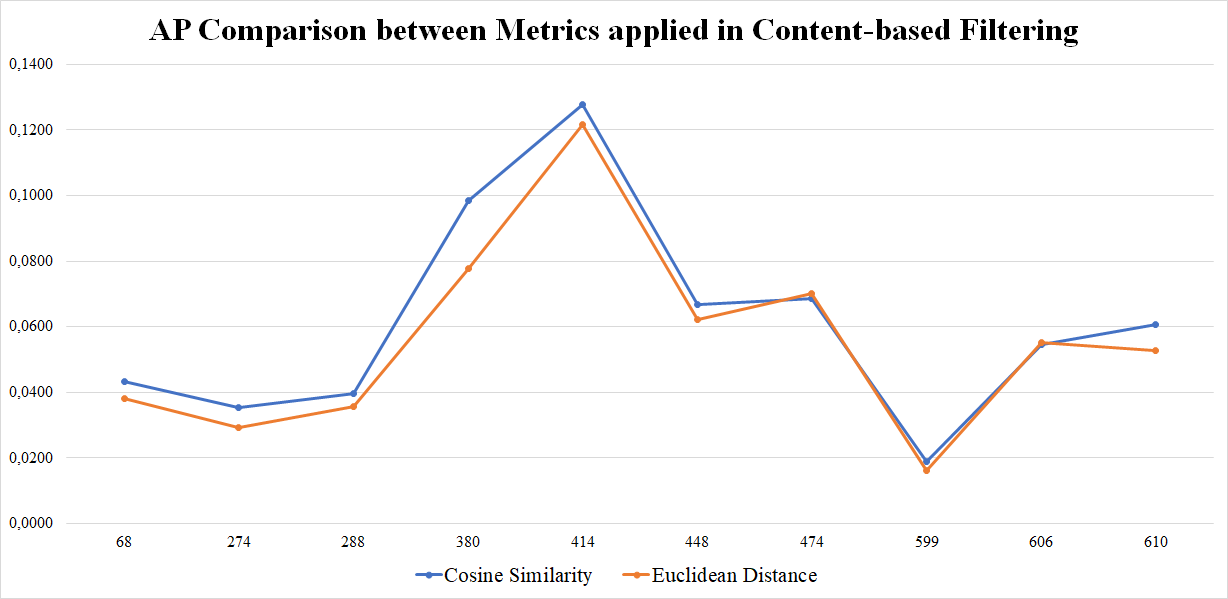



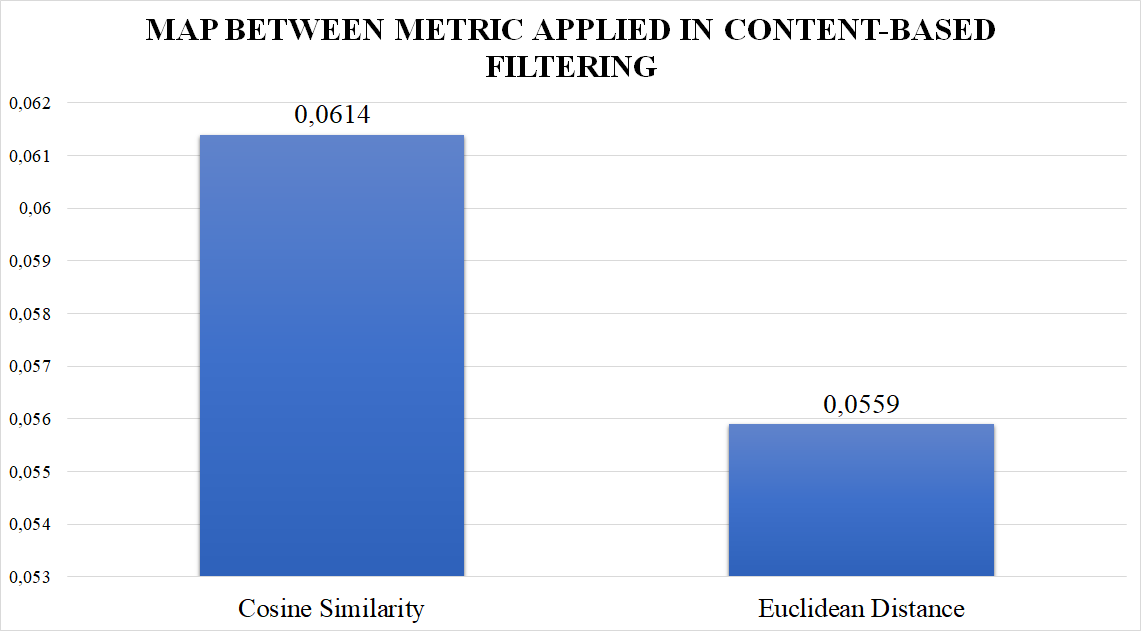

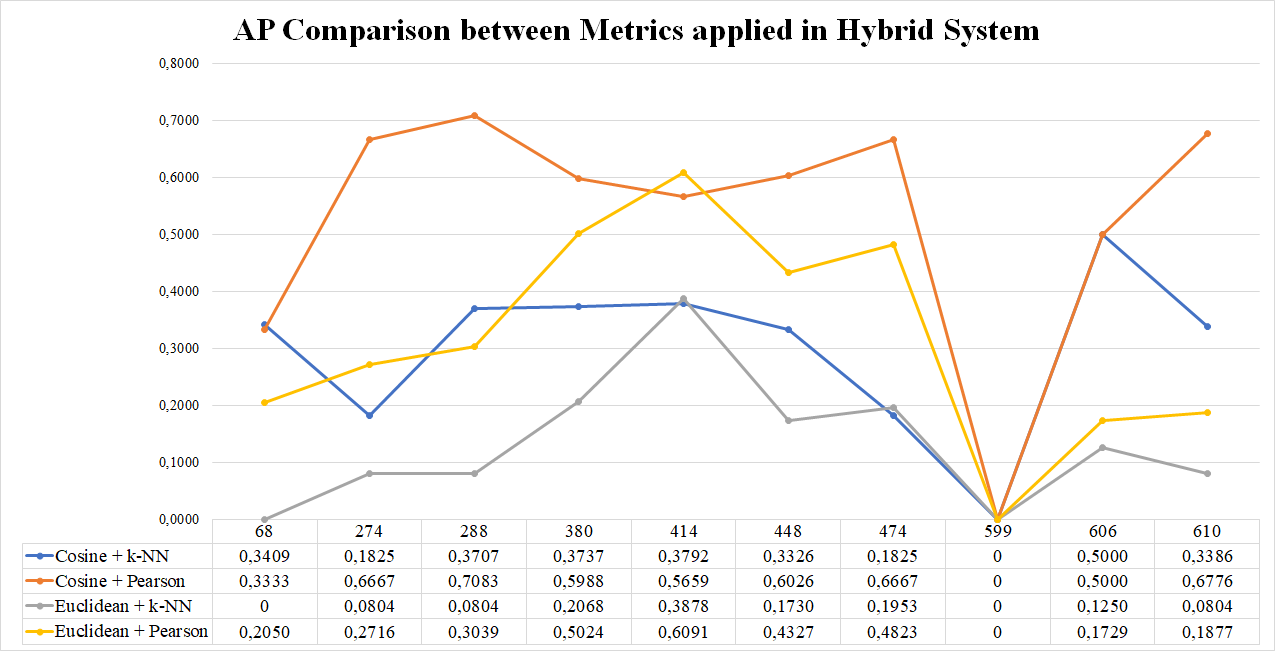

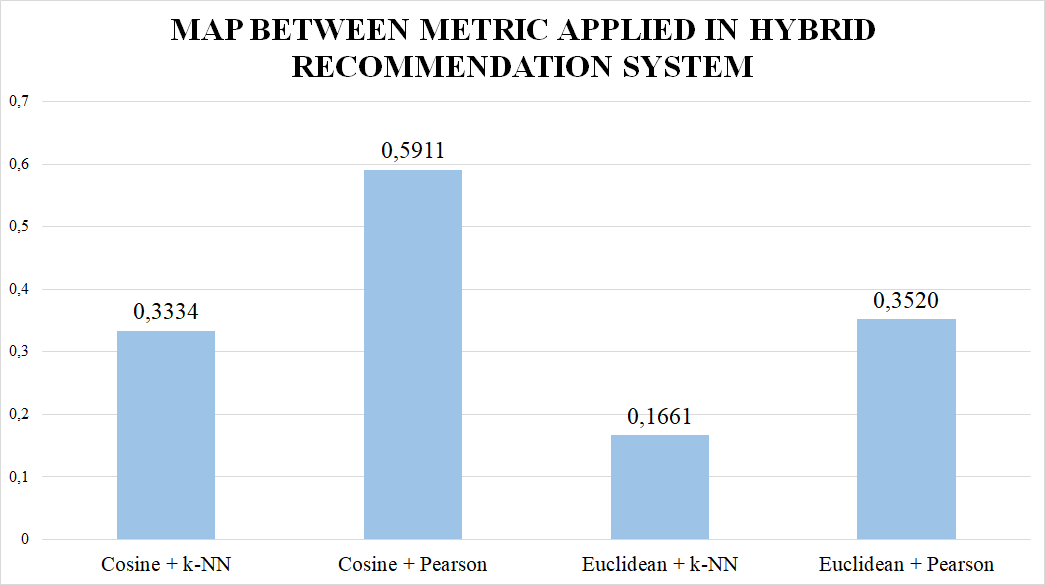

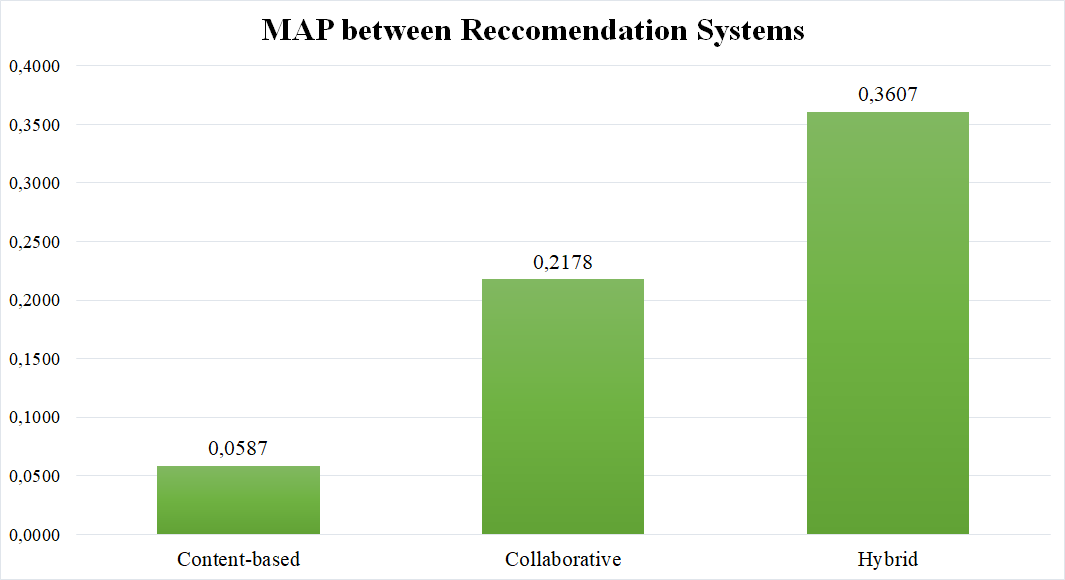